<a href="https://colab.research.google.com/github/middletonj1/Jame_Trials_Public/blob/master/Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# Make sure that you have all these libaries available to run the code successfully
%tensorflow_version 1.x
!pip install quandl
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import quandl
import math
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


TensorFlow is already loaded. Please restart the runtime to change versions.


In [98]:
quandl.ApiConfig.api_key = '94nMJrZnW1sCyPLjXzRB'
green_companies = quandl.get("NASDAQOMX/QGREEN")
EON = quandl.get("FSE/EON_X")
print(list(green_companies))

['Index Value', 'High', 'Low', 'Total Market Value', 'Dividend Market Value']


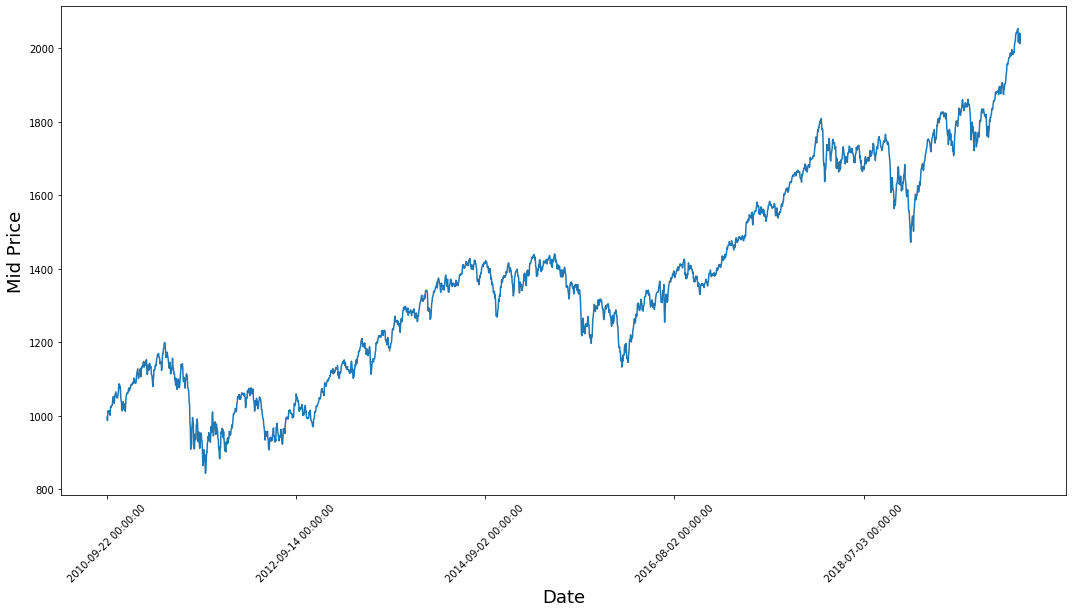

In [87]:
df = green_companies
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Index Value']))
plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [88]:
from math import floor
print(len(df),floor(len(df)*3/4),floor(len(df)*1/4))
train_data = df.iloc[:floor(len(df)*3/4)].values
test_data = df.iloc[floor(len(df)*1/4):].values

2416 1812 604


In [89]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(train_data)

[[9.96140000e+02]
 [1.00580000e+03]
 [9.92650000e+02]
 ...
 [1.64280000e+03]
 [2.10932578e+12]
 [2.31090700e+06]]


In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 450
for di in range(0,1800,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1812):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [0]:
from tensorflow.python.framework import ops
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

ops.reset_default_graph() # This is important in case you run this multiple times

In [96]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

AttributeError: ignored